In [155]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
from collections import namedtuple, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
from final_algo import attr_threshold, attr_threshold_new, SH_lambda_wrapper
from paper_sims_util import confusion, MCC_from_4
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
N = 500 #try for 25, 50, 200
p = 100
d = 0.01
if d is None:
    run_name = 'ROC_N_{}_p_{}'.format(N, p)
    d = 0.01
else:
    run_name = 'new_ROC/ROC_N_{}_p_{}_d_{}'.format(N, p, d)
NUM_GRAPHS = 30

In [16]:
try:
    df = pd.read_pickle('{}_new_graph.pkl'.format(run_name))
    print('Loaded df', df.RunID.nunique())
except:
    all_results = []
    data = []
    for graph_num in range(NUM_GRAPHS):
        print(graph_num)
    #     if graph_num in prev_df.RunID.values():
    #         continue #do not load
        try:
            res = pickle.load(open('{}_{}_result.pkl'.format(run_name, graph_num), 'rb'))
        except:
            continue
        result, FPTP_dict, omega, _, _ = res
        for algo_name in FPTP_dict.keys():
            for lamb in FPTP_dict[algo_name].keys():
                omega_hat = result[algo_name][lamb]
                TP, TN, FP, FN = confusion(omega_hat, omega)
                TPR = TP/(TP + FN)
                FPR = FP/(FP + TN)
                mcc = MCC_from_4(TP, TN, FP, FN)
                data.append((graph_num, algo_name, lamb, FPR, TPR, mcc, (TP, TN, FP, FN)))
# df.to_pickle('{}_df.pkl'.format(run_name))
# print(len(all_results), 'unique runs')
        df = pd.DataFrame(data, columns = ['RunID', 'AlgoName', 'Lambda', 'FPR', 'TPR', 'MCC', 'TP_TN_FP_FN'])
        df['groupby_lambda'] = [x[1] if type(x) == tuple else x for x in df.Lambda.values]
        df.to_pickle('{}_new_graph.pkl'.format(run_name))
        

Loaded df 25


In [139]:
df[df.AlgoName == 'SH'].groupby_lambda.unique()

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [140]:
algo_name_max_min = {
    'our': (0.75, 0.95),
    'nbsel': (0.1/5, 0.484),
    'glasso': (0.1/5, 0.484),
    'SH': (0.01, 0.3),
    'anand': (0.1/5, 0.68),
}

In [162]:
agg_data = []
for key, item in df.groupby(['AlgoName', 'groupby_lambda']):
    theo = np.sqrt(np.log(100)/N)
    algo_name = key[0]
    lambda_min, lambda_max = algo_name_max_min[algo_name]
    item = item[(item.groupby_lambda <= lambda_max) & (item.groupby_lambda >= lambda_min)]
    if len(item) == 0:
        continue
        
    mcc = item.MCC.mean()
    lamb = key[1]
    x_axis = (lamb - lambda_min)/(lambda_max-lambda_min)
    mcc_std = item.MCC.std()
    tpr = item.TPR.mean()
    tpr_std = item.TPR.std()
    run_id = item.RunID
    agg_data.append((key[0], lamb, x_axis, mcc, mcc_std, tpr, tpr_std))

In [157]:
from paper_sims_util import random_graph, confusion, MCC_from_4

precs = []
mccs = defaultdict(list)
tprs = defaultdict(list)
for i in range(10):
    print(i)
    g = random_graph(100, 0.01)
    X = np.random.multivariate_normal(np.zeros(100), np.linalg.inv(g), 500)
    res, prec = SH_lambda_wrapper(X, [0.01, 0.03])
    precs.append(prec)
    for lamb in [0.01, 0.03]:
        omega_hat = res[lamb]
        TP, TN, FP, FN = confusion(omega_hat, g)
        mcc = MCC_from_4(TP, TN, FP, FN)
        mccs[lamb].append(mcc)
        tprs[lamb].append(TP/(TP + FN))

for lamb in [0.01, 0.03]:
    mcc = np.mean(mccs[lamb])
    mcc_std = np.std(mccs[lamb])
    tpr = np.mean(tprs[lamb])
    tpr_std = np.std(tprs[lamb])
    agg_data.append(('SH', lamb, lamb/0.3, mcc, mcc_std, tpr, tpr_std))

0
1
2
3
4
5
6
7
8
9


In [161]:
SH_new = agg_data[-2:]

In [163]:
agg_data.append(SH_new)

In [164]:
agg_df = pd.DataFrame(agg_data, columns = ['Algorithm', 'lamb', 'x_axis', 'mcc', 'mcc_std', 'tpr', 'tpr_std'])

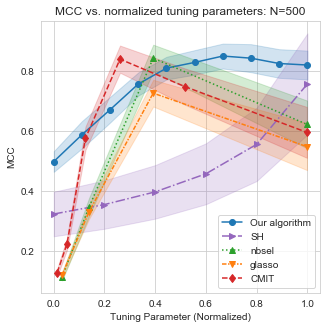

In [173]:
labels = {'our': 'Our algorithm', 
          'SH_0.7': 'SH:' + r'$t=0.7$', 
          'SH': 'SH', 
          'nbsel': 'nbsel', 
          'glasso': 'glasso', 
          'anand': 'CMIT',
          'our_85':  "Our algorithm: " + r'$\gamma=0.85$'}
markers = {'our': 'o', 'SH_0.7': '<', 'SH': '>', 'nbsel': '^', 'glasso': 'v', 'anand': 'd', 'our_85': '*'}
linestyles = {'our': 'solid', 
              'SH_0.7': 'dashdot', 
              'SH': 'dashdot', 
              'nbsel': 'dotted', 
              'glasso': (0, (3, 1, 1, 1)), 
              'anand': 'dashed',
              'our_85': 'solid'}
colors = {
    'our': 'C0',
    'glasso': 'C1',
    'nbsel': 'C2',
    'anand': 'C3',
    'SH': 'C4',
    'SH_0.7': 'C6',
    'our_85': 'C9'
}
fig = plt.figure(figsize=(5, 5))
ax = fig.gca()
ax.set_yticks(np.linspace(0, 1.0, 6))

#plt.xlim((0,1000))
all_algos = ['our', 'SH', 'nbsel', 'glasso', 'anand']
relevant_algos = ['our', 'SH']

smol = False
if smol:
    algos = relevant_algos
    ERRS = True
    small_name = 'errs'
else:
    algos = all_algos
    ERRS = True
    small_name = 'all'

for algo_name in algos:
    plot_df = agg_df[agg_df.Algorithm == algo_name]
    plot_df.sort_values('x_axis')
    x = plot_df['x_axis']
    if algo_name in ['SH', 'our']:
        x = np.flip(x)
    y = plot_df['mcc']
    std = plot_df['mcc_std']
#     y = plot_df['tpr']
#     std = plot_df['tpr_std']
    plt.plot(x, y,
             label = labels[algo_name],
             marker = markers[algo_name],
             linestyle = linestyles[algo_name],
             linewidth=1.5,
             color=colors[algo_name])
    if ERRS:
        plt.fill_between(x, y-std, y+std, alpha=0.2, color = colors[algo_name])
sns.set_style("whitegrid")
if smol:
    legend_loc = 'upper right'
else:
    legend_loc = 'lower right'
plt.legend(loc=legend_loc)
if smol:
    title = 'MCC for various tuning parameters with standard error: N={}'.format(N)
else:
    title = 'MCC vs. normalized tuning parameters: N={}'.format(N)
plt.title(title)
plt.xlabel("Tuning Parameter (Normalized)")
plt.ylabel("MCC")

plt.show()
fig.savefig('final_images/ALL_MCC_curves_{}_{}.png'.format(N, small_name))

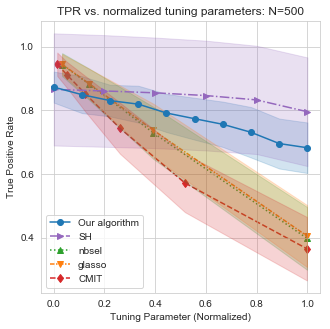

In [174]:
labels = {'our': 'Our algorithm', 
          'SH_0.7': 'SH:' + r'$t=0.7$', 
          'SH': 'SH', 
          'nbsel': 'nbsel', 
          'glasso': 'glasso', 
          'anand': 'CMIT',
          'our_85':  "Our algorithm: " + r'$\gamma=0.85$'}
markers = {'our': 'o', 'SH_0.7': '<', 'SH': '>', 'nbsel': '^', 'glasso': 'v', 'anand': 'd', 'our_85': '*'}
linestyles = {'our': 'solid', 
              'SH_0.7': 'dashdot', 
              'SH': 'dashdot', 
              'nbsel': 'dotted', 
              'glasso': (0, (3, 1, 1, 1)), 
              'anand': 'dashed',
              'our_85': 'solid'}
colors = {
    'our': 'C0',
    'glasso': 'C1',
    'nbsel': 'C2',
    'anand': 'C3',
    'SH': 'C4',
    'SH_0.7': 'C6',
    'our_85': 'C9'
}

zorders = defaultdict(int)
zorders['our'] = 10
zorders['SH'] = 8
fig = plt.figure(figsize=(5, 5))
ax = fig.gca()
ax.set_yticks(np.linspace(0, 1.0, 6))

#plt.xlim((0,1000))
all_algos = ['our', 'SH', 'nbsel', 'glasso', 'anand']
relevant_algos = ['our', 'SH']

smol = False
if smol:
    algos = relevant_algos
    ERRS = True
    small_name = 'errs'
else:
    algos = all_algos
    ERRS = True
    small_name = 'all'

for algo_name in algos:
    plot_df = agg_df[agg_df.Algorithm == algo_name]
    plot_df.sort_values('x_axis')
    x = plot_df['x_axis']
    if algo_name in ['SH', 'our']:
        x = np.flip(x)
    y = plot_df['tpr']
    std = plot_df['tpr_std']
#     y = plot_df['tpr']
#     std = plot_df['tpr_std']
    plt.plot(x, y,
             label = labels[algo_name],
             marker = markers[algo_name],
             linestyle = linestyles[algo_name],
             linewidth=1.5,
             color=colors[algo_name],
             zorder = zorders[algo_name])
    if ERRS:
        plt.fill_between(x, y-std, y+std, alpha=0.2, color = colors[algo_name])
sns.set_style("whitegrid")
if smol:
    legend_loc = 'upper left'
else:
    legend_loc = 'lower left'
plt.legend(loc=legend_loc)
if smol:
    title = 'TPR for various tuning parameters with standard error: N={}'.format(N)
else:
    title = 'TPR vs. normalized tuning parameters: N={}'.format(N)
plt.title(title)
plt.xlabel("Tuning Parameter (Normalized)")
plt.ylabel("True Positive Rate")

plt.show()
fig.savefig('final_images/ALL_TPR_curves_{}_{}.png'.format(N, small_name))